In [6]:
from theano.sandbox import cuda

In [7]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

In [8]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [9]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [11]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [15]:
movie_names


{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cit\xc3\xa9 des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkey

In [12]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [17]:
users[:5]

array([1, 2, 3, 4, 5])

In [13]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [19]:
userid2idx

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [14]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [15]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [22]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [16]:
n_factors = 50

In [17]:
np.random.seed = 42

Randomly split into training and validation.

In [18]:
msk = np.random.rand(len(ratings)) < 0.8
len(ratings),msk

(100004, array([ True,  True,  True, ...,  True,  True,  True], dtype=bool))

In [19]:
trn = ratings[msk]
val = ratings[~msk]
len(trn),len(val)

(80036, 19968)

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [20]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]
g,topUsers

(userId
 0        20
 1        76
 2        51
 3       204
 4       100
 5        44
 6        88
 7       116
 8        45
 9        46
 10       38
 11       61
 12       53
 13       20
 14     1700
 15       29
 16      363
 17       51
 18      423
 19       98
 20      162
 21      220
 22      726
 23       21
 24       26
 25      172
 26       23
 27       50
 28       22
 29     1011
        ... 
 641      36
 642      24
 643      39
 644      30
 645     169
 646     150
 647     256
 648      90
 649      29
 650      20
 651     267
 652      51
 653     626
 654     105
 655     128
 656      20
 657      60
 658     142
 659      92
 660      33
 661      58
 662      26
 663     519
 664     434
 665      40
 666      68
 667      20
 668      37
 669      31
 670     115
 Name: rating, Length: 671, dtype: int64, userId
 546    2391
 563    1868
 623    1735
 14     1700
 72     1610
 451    1340
 467    1291
 379    1063
 310    1019
 29     1011
 293     947
 508   

In [42]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [55]:
ratings.head()

,userId,movieId,rating,timestamp
0,0,0,2.5,1260759144
1,0,1,3.0,1260759179
2,0,2,3.0,1260759182
3,0,3,2.0,1260759185
4,0,4,4.0,1260759205


In [56]:
topUsers.head()

userId
546    2391
563    1868
623    1735
14     1700
72     1610
Name: rating, dtype: int64

In [65]:
top_r = ratings.join(topUsers, rsuffix='_count_by_person', how='inner', on='userId')

In [66]:
top_r.head()

,userId,movieId,rating,timestamp,rating_count_by_person
962,14,417,2.0,997938310,1700
963,14,650,2.0,1134521380,1700
964,14,651,4.5,1093070098,1700
965,14,652,4.0,1040205753,1700
966,14,20,3.0,1093028290,1700


In [59]:
len(top_r)

19606

In [67]:
top_r = top_r.join(topMovies, rsuffix='_persons_count', how='inner', on='movieId')

In [68]:
top_r.head()


,userId,movieId,rating,timestamp,rating_count_by_person,rating_persons_count
962,14,417,2.0,997938310,1700,247
5048,29,417,4.0,944943070,1011,247
10214,72,417,5.0,1303464840,1610,247
28390,211,417,3.0,1218405007,876,247
29266,212,417,3.0,1462637445,910,247


In [69]:
len(top_r)

206

In [45]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [70]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [71]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [72]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/1
80255/80255 [==============================] - 8s - loss: 9.8682 - val_loss: 4.2768


In [73]:
model.optimizer.lr=0.01

In [74]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/3
80255/80255 [==============================] - 9s - loss: 3.1326 - val_loss: 2.8113
Epoch 2/3
80255/80255 [==============================] - 9s - loss: 2.3882 - val_loss: 2.6061
Epoch 3/3
80255/80255 [==============================] - 9s - loss: 2.2105 - val_loss: 2.5570


In [75]:
model.optimizer.lr=0.001

In [76]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/6
80255/80255 [==============================] - 8s - loss: 2.1443 - val_loss: 2.5543
Epoch 2/6
80255/80255 [==============================] - 9s - loss: 2.1080 - val_loss: 2.5485
Epoch 3/6
80255/80255 [==============================] - 9s - loss: 2.0832 - val_loss: 2.5562
Epoch 4/6
80255/80255 [==============================] - 9s - loss: 2.0643 - val_loss: 2.5626
Epoch 5/6
80255/80255 [==============================] - 9s - loss: 2.0474 - val_loss: 2.5643
Epoch 6/6
80255/80255 [==============================] - 9s - loss: 2.0285 - val_loss: 2.5753


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [3]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [78]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [79]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [80]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [81]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [82]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/1
80255/80255 [==============================] - 9s - loss: 8.8390 - val_loss: 3.5195


In [83]:
model.optimizer.lr=0.01

In [84]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/6
80255/80255 [==============================] - 9s - loss: 2.5799 - val_loss: 2.2979
Epoch 2/6
80255/80255 [==============================] - 10s - loss: 1.9807 - val_loss: 2.1032
Epoch 3/6
80255/80255 [==============================] - 10s - loss: 1.8216 - val_loss: 2.0084
Epoch 4/6
80255/80255 [==============================] - 10s - loss: 1.7279 - val_loss: 1.9390
Epoch 5/6
80255/80255 [==============================] - 10s - loss: 1.6505 - val_loss: 1.8679
Epoch 6/6
80255/80255 [==============================] - 10s - loss: 1.5770 - val_loss: 1.8039


In [85]:
model.optimizer.lr=0.001

In [86]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/10
80255/80255 [==============================] - 9s - loss: 1.5067 - val_loss: 1.7413
Epoch 2/10
80255/80255 [==============================] - 10s - loss: 1.4379 - val_loss: 1.6783
Epoch 3/10
80255/80255 [==============================] - 10s - loss: 1.3703 - val_loss: 1.6215
Epoch 4/10
80255/80255 [==============================] - 9s - loss: 1.3059 - val_loss: 1.5674
Epoch 5/10
80255/80255 [==============================] - 9s - loss: 1.2425 - val_loss: 1.5146
Epoch 6/10
80255/80255 [==============================] - 10s - loss: 1.1825 - val_loss: 1.4684
Epoch 7/10
80255/80255 [==============================] - 10s - loss: 1.1243 - val_loss: 1.4240
Epoch 8/10
80255/80255 [==============================] - 10s - loss: 1.0697 - val_loss: 1.3782
Epoch 9/10
80255/80255 [==============================] - 10s - loss: 1.0187 - val_loss: 1.3349
Epoch 10/10
80255/80255 [==============================] - 10s - loss: 0.9696 - val_loss:

In [87]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/5
80255/80255 [==============================] - 9s - loss: 0.9238 - val_loss: 1.2661
Epoch 2/5
80255/80255 [==============================] - 9s - loss: 0.8806 - val_loss: 1.2313
Epoch 3/5
80255/80255 [==============================] - 10s - loss: 0.8410 - val_loss: 1.2042
Epoch 4/5
80255/80255 [==============================] - 10s - loss: 0.8035 - val_loss: 1.1776
Epoch 5/5
80255/80255 [==============================] - 10s - loss: 0.7693 - val_loss: 1.1534


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [88]:
model.save_weights(model_path+'bias.h5')

In [89]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [90]:
model.predict([np.array([3]), np.array([6])])

array([[ 5.1189]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [91]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [92]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [93]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.35632432, 'Battlefield Earth (2000)'),
 (-0.10461789, 'Super Mario Bros. (1993)'),
 (-0.029554501, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.01320884, 'Police Academy 6: City Under Siege (1989)'),
 (-0.012489938, 'Jaws 3-D (1983)'),
 (0.0013548357, 'Bio-Dome (1996)'),
 (0.0086163161, 'Speed 2: Cruise Control (1997)'),
 (0.011880738, 'Little Nicky (2000)'),
 (0.05993709, 'Blade: Trinity (2004)'),
 (0.075198017, 'Blair Witch Project, The (1999)'),
 (0.091148794, 'Howard the Duck (1986)'),
 (0.10053153, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (0.10891724, 'Blame It on Rio (1984)'),
 (0.1094185, 'Spice World (1997)'),
 (0.11562212, 'Wild Wild West (1999)')]

In [94]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.4443141, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.4304783, 'The Theory of Everything (2014)'),
 (1.406916, '3:10 to Yuma (2007)'),
 (1.3799306, 'Mississippi Burning (1988)'),
 (1.3556089, 'Rush (2013)'),
 (1.351729, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3434023, 'Tom Jones (1963)'),
 (1.3132237, 'Shawshank Redemption, The (1994)'),
 (1.3127303, 'Argo (2012)'),
 (1.312288, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3090993, 'Cyrano de Bergerac (1990)'),
 (1.3006768, 'Smoke (1995)'),
 (1.2905658, 'Killer, The (Die xue shuang xiong) (1989)'),
 (1.2894666, 'Blood Simple (1984)'),
 (1.2888217, 'Last King of Scotland, The (2006)')]

We can now do the same thing for the embeddings.

In [95]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [96]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [97]:
fac0 = movie_pca[0]

In [98]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [99]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.052571837, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.051648602, 'Usual Suspects, The (1995)'),
 (0.049072672, 'American History X (1998)'),
 (0.048481319, 'Shawshank Redemption, The (1994)'),
 (0.048310746, "Schindler's List (1993)"),
 (0.048220731, "Amelie (Fabuleux destin d'Am\xc3\xa9lie Poulain, Le) (2001)"),
 (0.048183482, 'Stand by Me (1986)'),
 (0.04817348, 'Dark Knight, The (2008)'),
 (0.048107199, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.048087817, 'Seven (a.k.a. Se7en) (1995)')]

In [100]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.012997245, 'Anaconda (1997)'),
 (-0.010319937, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.0092126168, 'Battlefield Earth (2000)'),
 (-0.0083373692, 'House on Haunted Hill (1999)'),
 (-0.0082234219, 'RoboCop 3 (1993)'),
 (-0.0075571788, 'Jaws 3-D (1983)'),
 (-0.0073223994, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.0071483226, 'Grease 2 (1982)'),
 (-0.007144405, "You Don't Mess with the Zohan (2008)"),
 (-0.0070660035, 'X-Men Origins: Wolverine (2009)')]

In [101]:
fac1 = movie_pca[1]

In [102]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [103]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.061673578, 'Clockwork Orange, A (1971)'),
 (0.061388187, 'Brokeback Mountain (2005)'),
 (0.060851995, '8 1/2 (8\xc2\xbd) (1963)'),
 (0.057721023, 'Annie Hall (1977)'),
 (0.057699695, 'City Lights (1931)'),
 (0.055786539, 'Apocalypse Now (1979)'),
 (0.054331001, 'Royal Tenenbaums, The (2001)'),
 (0.053182937, 'Harold and Maude (1971)'),
 (0.050021991, 'No Country for Old Men (2007)'),
 (0.04962137, '2001: A Space Odyssey (1968)')]

In [104]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.096115455, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.090580225, 'Armageddon (1998)'),
 (-0.079347208, 'Speed (1994)'),
 (-0.077193387, 'Stargate (1994)'),
 (-0.073807225, 'Ghost (1990)'),
 (-0.073267579, 'Jurassic Park (1993)'),
 (-0.072732069, 'Titanic (1997)'),
 (-0.068245374, 'Ace Ventura: Pet Detective (1994)'),
 (-0.066263214, 'X-Men (2000)'),
 (-0.065846667, 'Mission: Impossible II (2000)')]

In [105]:
fac2 = movie_pca[2]

In [106]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [107]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.14479154, 'Silence of the Lambs, The (1991)'),
 (0.13576177, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.10743178, 'Pulp Fiction (1994)'),
 (0.10547227, '2001: A Space Odyssey (1968)'),
 (0.099468201, 'Fargo (1996)'),
 (0.099103734, 'Leaving Las Vegas (1995)'),
 (0.08561378, 'Taxi Driver (1976)'),
 (0.077354141, 'American Beauty (1999)'),
 (0.076806761, 'Usual Suspects, The (1995)'),
 (0.07627251, 'Fear and Loathing in Las Vegas (1998)')]

In [108]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.078095146, 'Legally Blonde (2001)'),
 (-0.073417202, 'Chicken Run (2000)'),
 (-0.067988254, 'Double Jeopardy (1999)'),
 (-0.061370153, 'Secret of NIMH, The (1982)'),
 (-0.061246179, 'Ice Age (2002)'),
 (-0.060592845, 'Miss Congeniality (2000)'),
 (-0.060534805, 'Superman II (1980)'),
 (-0.059897665, 'Lilo & Stitch (2002)'),
 (-0.058108218,
  'Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)'),
 (-0.055798713, 'Sabrina (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [109]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

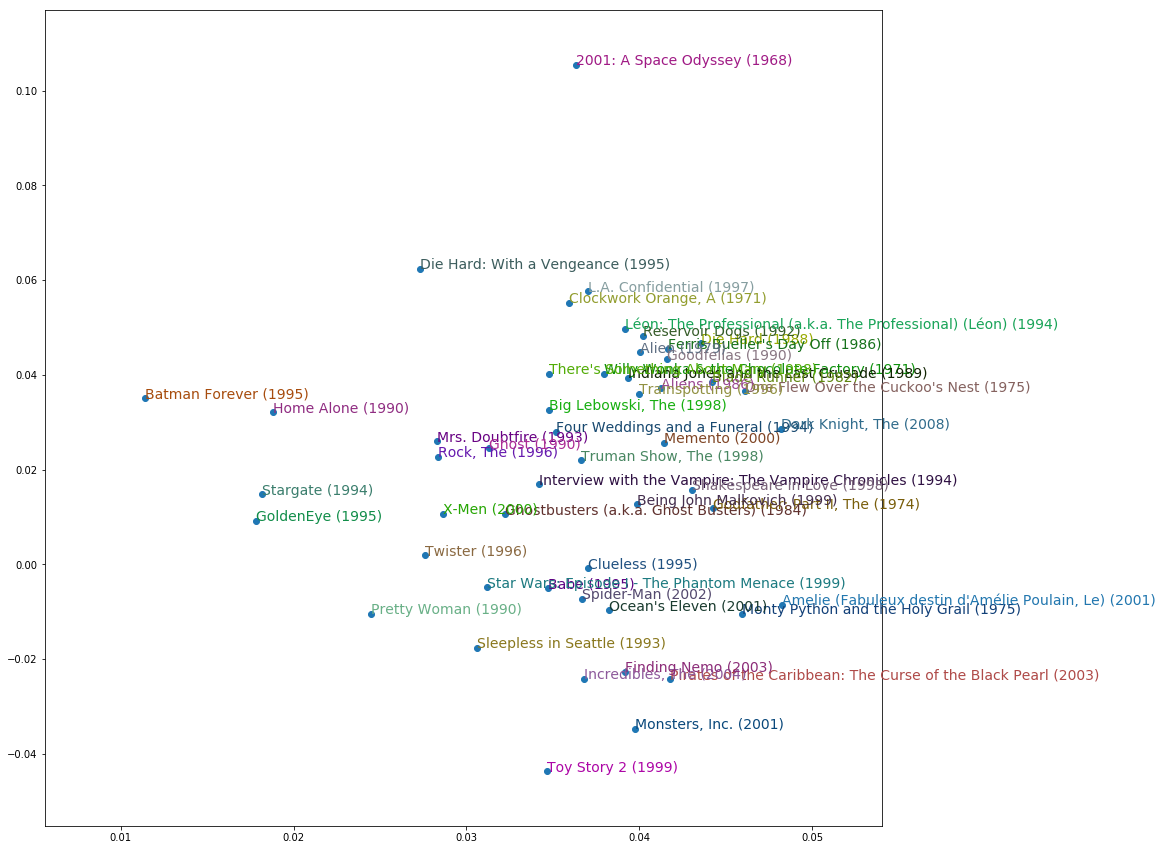

In [110]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [26]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [23]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [25]:
user_in, u

(<tf.Tensor 'user_in:0' shape=(?, 1) dtype=int64>,
 <tf.Tensor 'Gather:0' shape=(?, 1, 50) dtype=float32>)

In [112]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [113]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80255 samples, validate on 19749 samples
Epoch 1/8
80255/80255 [==============================] - 11s - loss: 2.3662 - val_loss: 0.9232
Epoch 2/8
80255/80255 [==============================] - 11s - loss: 1.4398 - val_loss: 0.8724
Epoch 3/8
80255/80255 [==============================] - 12s - loss: 1.2153 - val_loss: 0.8663
Epoch 4/8
80255/80255 [==============================] - 12s - loss: 1.0313 - val_loss: 0.8434
Epoch 5/8
80255/80255 [==============================] - 11s - loss: 0.9101 - val_loss: 0.8365
Epoch 6/8
80255/80255 [==============================] - 11s - loss: 0.8482 - val_loss: 0.8347
Epoch 7/8
80255/80255 [==============================] - 11s - loss: 0.8214 - val_loss: 0.8327
Epoch 8/8
80255/80255 [==============================] - 11s - loss: 0.8107 - val_loss: 0.8346


This improves on our already impressive accuracy even further!